In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import re
import requests # get url data
from bs4 import BeautifulSoup # manipulate url data
import json
from pandas import DataFrame as df

### Data collecting from url

In [2]:
web_page = requests.get('https://www.worldometers.info/coronavirus')
soup = BeautifulSoup(web_page.text, 'html.parser')
#print(soup.prettify())

In [3]:
### basic data 

covid_data = soup.find_all('div', class_='maincounter-number')
print('Coronavirus Cases:', covid_data[0].text.strip())
print('Coronavirus Deaths:', covid_data[1].text.strip())
print('Coronavirus Recovered:', covid_data[2].text.strip())

Coronavirus Cases: 704,753,890
Coronavirus Deaths: 7,010,681
Coronavirus Recovered: 675,619,811


In [4]:
data = soup.find_all('script', {'type': 'text/javascript'})
#for i in data:
#    print(i)

results = soup.find(id='main_table_countries_today')
content = results.find_all('td')
#content

##### got the right data that i want to collect. now cleaning the data

In [5]:
clean_data =""
for i in content:
    clean_data += i.text.strip() + "|"
    clean_data = clean_data.replace("+", "")
    clean_data = clean_data.replace("N/A", "0")
#clean_data

In [6]:
#country list from the website

countries = [
    'USA', 'India', 'France', 'Germany', 'Brazil', 'S. Korea', 'Japan', 'Italy', 'UK', 'Russia', 'Turkey',
    'Spain', 'Australia', 'Vietnam', 'Taiwan', 'Argentina', 'Netherlands', 'Mexico', 'Iran', 'Indonesia', 'Poland',
    'Colombia', 'Greece', 'Austria', 'Portugal', 'Ukraine', 'Chile', 'Malaysia', 'Canada', 'Belgium', 'Israel',
    'DPRK', 'Thailand', 'Czechia', 'Peru', 'Switzerland', 'Philippines', 'South Africa', 'Romania', 'Denmark', 
    'Singapore', 'Hong Kong', 'Sweden', 'New Zealand', 'Serbia', 'Iraq', 'Hungary', 'Bangladesh', 'Slovakia', 
    'Georgia', 'Jordan', 'Ireland', 'Pakistan', 'Finland', 'Norway', 'Kazakhstan', 'Lithuania', 'Slovenia', 
    'Bulgaria', 'Croatia', 'Guatemala', 'Morocco', 'Lebanon', 'Costa Rica', 'Bolivia', 'Tunisia', 'Cuba', 
    'Ecuador', 'UAE', 'Panama', 'Uruguay', 'Mongolia', 'Nepal', 'Belarus', 'Latvia', 'Saudi Arabia', 'Paraguay', 
    'Azerbaijan', 'Bahrain', 'Cyprus', 'Dominican Republic', 'Sri Lanka', 'Kuwait', 'Myanmar', 'Moldova', 'Estonia', 
    'Palestine', 'Venezuela', 'Egypt', 'Qatar', 'Libya', 'China', 'Ethiopia', 'Réunion', 'Honduras', 'Armenia', 
    'Bosnia and Herzegovina', 'Oman', 'Luxembourg', 'North Macedonia', 'Zambia', 'Kenya', 'Brunei', 'Albania', 
    'Botswana', 'Montenegro', 'Algeria', 'Nigeria', 'Zimbabwe', 'Uzbekistan', 'Afghanistan', 'Mozambique', 
    'Martinique', 'Laos', 'Iceland', 'Kyrgyzstan', 'Guadeloupe', 'El Salvador', 'Trinidad and Tobago', 'Maldives', 
    'Namibia', 'Uganda', 'Ghana', 'Jamaica', 'Cambodia', 'Rwanda', 'Cameroon', 'Malta', 'Barbados', 'Angola', 
    'Channel Islands', 'DRC', 'French Guiana', 'Malawi', 'Senegal', 'Ivory Coast', 'Suriname', 'New Caledonia', 
    'French Polynesia', 'Eswatini', 'Guyana', 'Belize', 'Fiji', 'Madagascar', 'Cabo Verde', 'Sudan', 'Mauritania', 
    'Bhutan', 'Syria', 'Burundi', 'Seychelles', 'Gabon', 'Andorra', 'Papua New Guinea', 'Curaçao', 'Aruba', 
    'Tanzania', 'Mauritius', 'Mayotte', 'Togo', 'Guinea', 'Bahamas', 'Isle of Man', 'Lesotho', 'Haiti', 
    'Faeroe Islands', 'Mali', 'Cayman Islands', 'Saint Lucia', 'Benin', 'Macao', 'Somalia', 'Micronesia', 
    'San Marino', 'Solomon Islands', 'Congo', 'Timor-Leste', 'Burkina Faso', 'Liechtenstein', 'Gibraltar', 
    'Grenada', 'Bermuda', 'South Sudan', 'Nicaragua', 'Tajikistan', 'Equatorial Guinea', 'Monaco', 'Samoa', 
    'Tonga', 'Marshall Islands', 'Dominica', 'Djibouti', 'CAR', 'Gambia', 'Saint Martin', 'Vanuatu', 'Greenland', 
    'Yemen', 'Caribbean Netherlands', 'Sint Maarten', 'Eritrea', 'Niger', 'St. Vincent Grenadines', 'Guinea-Bissau', 
    'Comoros', 'Antigua and Barbuda', 'Liberia', 'Sierra Leone', 'Chad', 'British Virgin Islands', 'Cook Islands', 
    'Sao Tome and Principe', 'Turks and Caicos', 'Saint Kitts and Nevis', 'Palau', 'St. Barth', 'Nauru', 'Kiribati', 
    'Anguilla', 'Wallis and Futuna', 'Saint Pierre Miquelon', 'Tuvalu', 'Saint Helena', 'Falkland Islands', 
    'Montserrat', 'Niue', 'Diamond Princess', 'Tokelau', 'Vatican City', 'Western Sahara', 'MS Zaandam'
]

data_dict = {}

for c in countries:
    pattern = c+"[,|\d]*"
    data = re.search(pattern, clean_data, re.IGNORECASE)
    if data is not None:
        data_dict[c]= data.group()

In [7]:
#data_dict

In [8]:
# Define column names from the web
columns = ["country", "total_cases", "Blank1", "total+_deaths", "Blank2", "total_recovered", "Blank3", 
           "active_cases", "serious_critical", "total_cases/1M","deaths/1M", "total_tests", 
           "tests_per_million", "population"]

data_rows = []
for key, value in data_dict.items():
    split_data = value.split("|")
    # Ensure each row has exactly 14 fields by truncating or padding with None
    split_data = split_data[:14] if len(split_data) >= 14 else split_data + [None] * (14 - len(split_data))
    data_rows.append(split_data)
    
df = pd.DataFrame(data_rows, columns=columns)
df = df.dropna(axis=0, how='all')
df = df.drop(columns=["Blank1", "Blank2", "Blank3"])
#df.to_csv("covid_data.csv", index=False) 
df

,country,total_cases,total+_deaths,total_recovered,active_cases,serious_critical,total_cases/1M,deaths/1M,total_tests,tests_per_million,population
0,USA,"111,820,082","1,219,487","109,814,428","786,167",940,"333,985","3,642","1,186,851,502","3,544,901","334,805,269"
1,India,"45,035,393","533,570",0,0,0,"32,016",379,"935,879,495","665,334","1,406,631,776"
2,France,"40,138,560","167,642","39,970,918",0,,"612,013","2,556","271,490,188","4,139,547","65,584,518"
3,Germany,"38,828,995","183,027","38,240,600","405,368",0,"462,891","2,182","122,332,384","1,458,359","83,883,596"
4,Brazil,"38,743,918","711,380","36,249,161","1,783,377",0,"179,908","3,303","63,776,166","296,146","215,353,593"
...,...,...,...,...,...,...,...,...,...,...,...
226,Diamond Princess,712,13,699,0,,,,,,
227,Tokelau,80,,,80,,"58,055",,,,"1,378"
228,Vatican City,29,,29,0,,"36,295",,,,799
229,Western Sahara,10,1,9,0,,16,2,,,"626,161"


In [9]:
df

,country,total_cases,total+_deaths,total_recovered,active_cases,serious_critical,total_cases/1M,deaths/1M,total_tests,tests_per_million,population
0,USA,"111,820,082","1,219,487","109,814,428","786,167",940,"333,985","3,642","1,186,851,502","3,544,901","334,805,269"
1,India,"45,035,393","533,570",0,0,0,"32,016",379,"935,879,495","665,334","1,406,631,776"
2,France,"40,138,560","167,642","39,970,918",0,,"612,013","2,556","271,490,188","4,139,547","65,584,518"
3,Germany,"38,828,995","183,027","38,240,600","405,368",0,"462,891","2,182","122,332,384","1,458,359","83,883,596"
4,Brazil,"38,743,918","711,380","36,249,161","1,783,377",0,"179,908","3,303","63,776,166","296,146","215,353,593"
...,...,...,...,...,...,...,...,...,...,...,...
226,Diamond Princess,712,13,699,0,,,,,,
227,Tokelau,80,,,80,,"58,055",,,,"1,378"
228,Vatican City,29,,29,0,,"36,295",,,,799
229,Western Sahara,10,1,9,0,,16,2,,,"626,161"


214
Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')


<Axes: xlabel='date'>

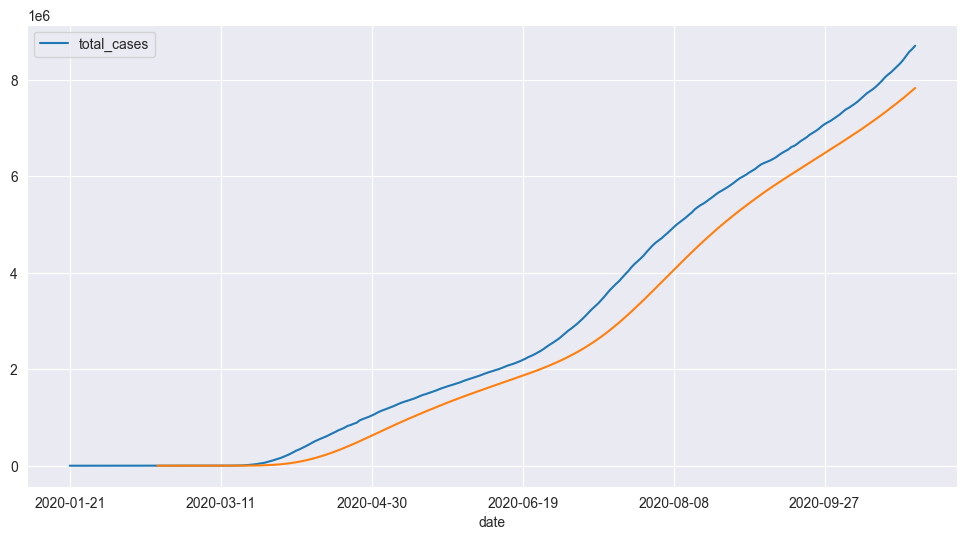

In [10]:
df = pd.read_csv('data/owid-covid-data.csv')
country_df = df.location.unique()
print(country_df.size)
print(df.columns)

indexer =df[df['location']=='United States'].index
us_tc = df.loc[indexer, 'date':'total_cases']
us_tc= us_tc.dropna()
us_tc.set_index('date', inplace=True)
us_tc.plot(figsize=(12,6))
us_tc.rolling(window=30).mean()['total_cases'].plot()

###### since total cases are higher than avg. as time went by, the scenario was pretty bad

### Did lockdowns work?

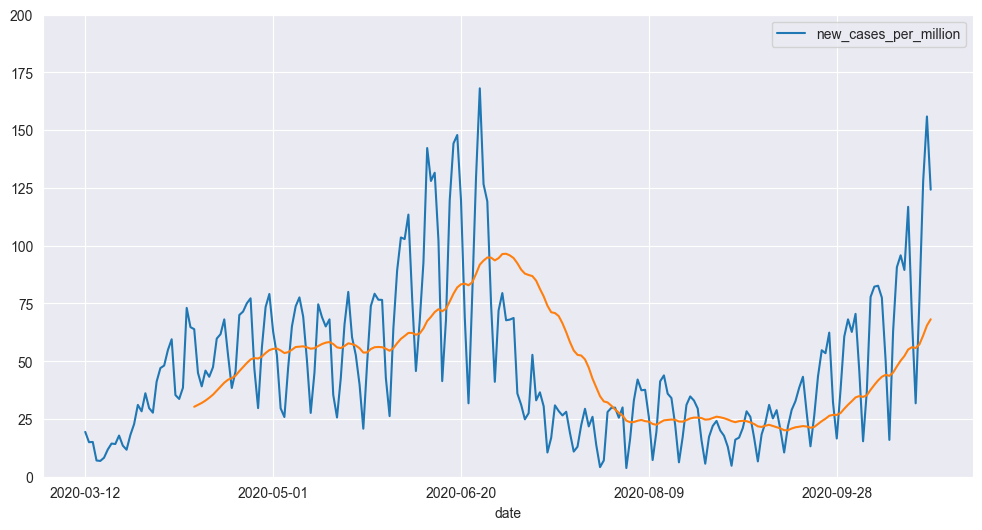

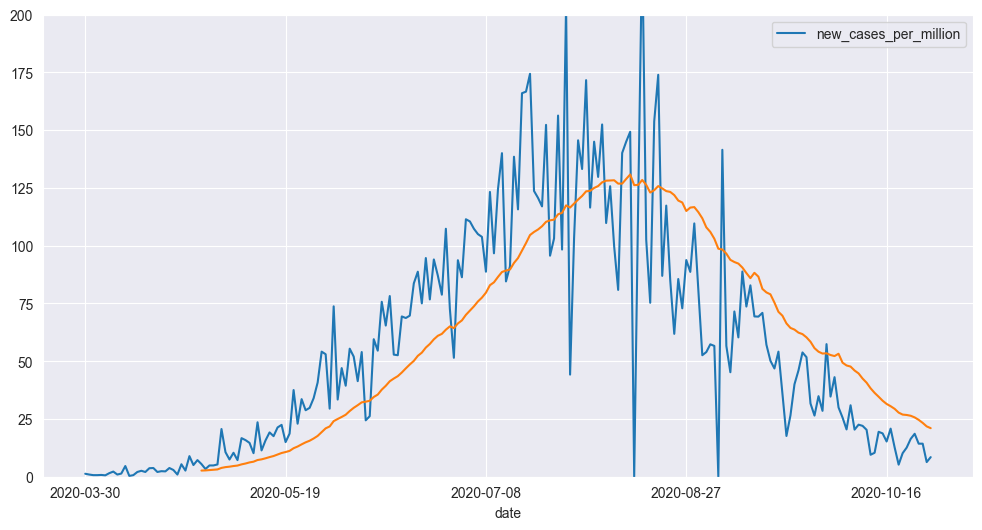

In [11]:
def plot_covid_data(country, col, plot_ma=False,y_max=200):
    indexer =df[df['location']==country].index
    df_country = df.loc[indexer, 'date':col]
    df_country= df_country.dropna()
    df_country.set_index('date', inplace=True)
    df_country.drop(df_country.columns.difference([col]), axis=1, inplace=True)
    df_country.plot(figsize=(12,6), ylim=[0,y_max])
    
    if plot_ma:
        df_country.rolling(window=30).mean()[col].plot()
        
        
plot_covid_data('Sweden', 'new_cases_per_million', True)
plot_covid_data('Bolivia', 'new_cases_per_million', True)

#### How does median age effect death rate?

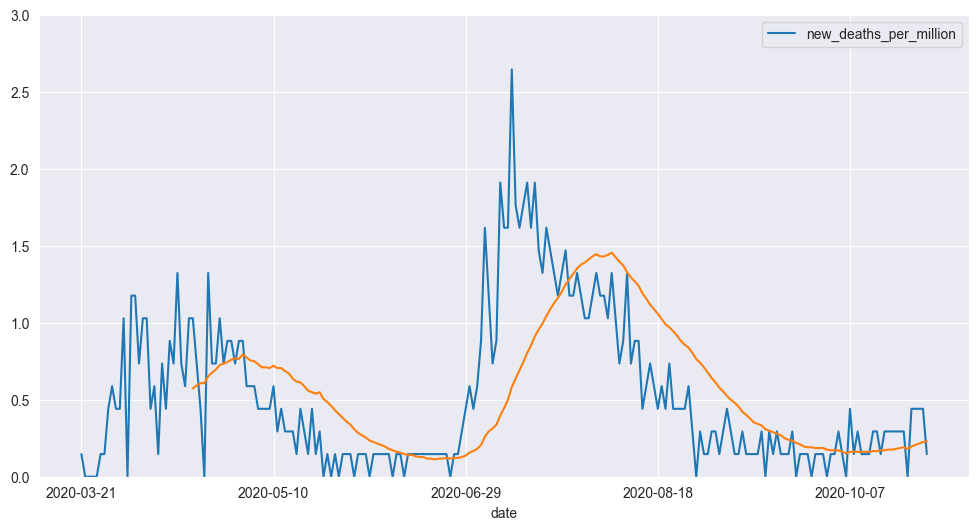

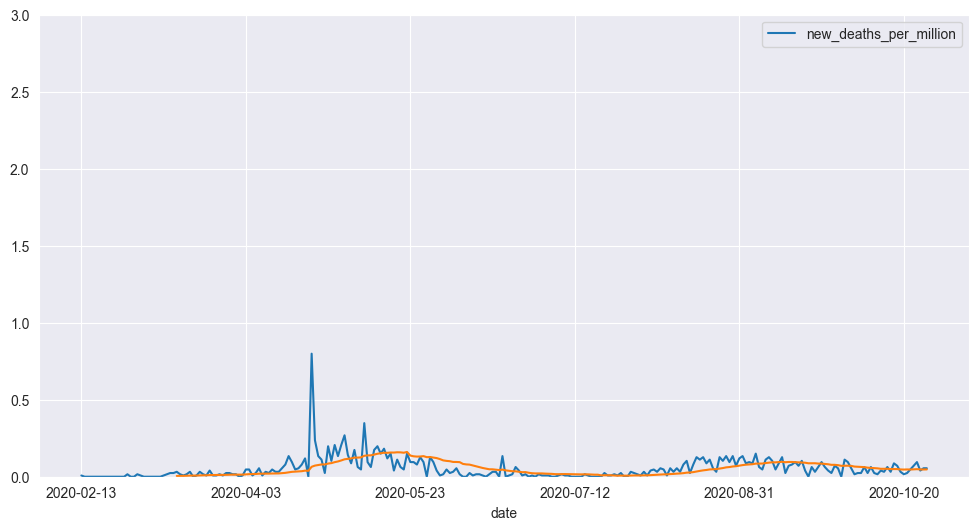

In [12]:
plot_covid_data('Serbia', 'new_deaths_per_million', True, 3) # Serbia had low median age
plot_covid_data('Japan', 'new_deaths_per_million', True, 3) #japan had old median age

#### How does obesity effect Death rate?

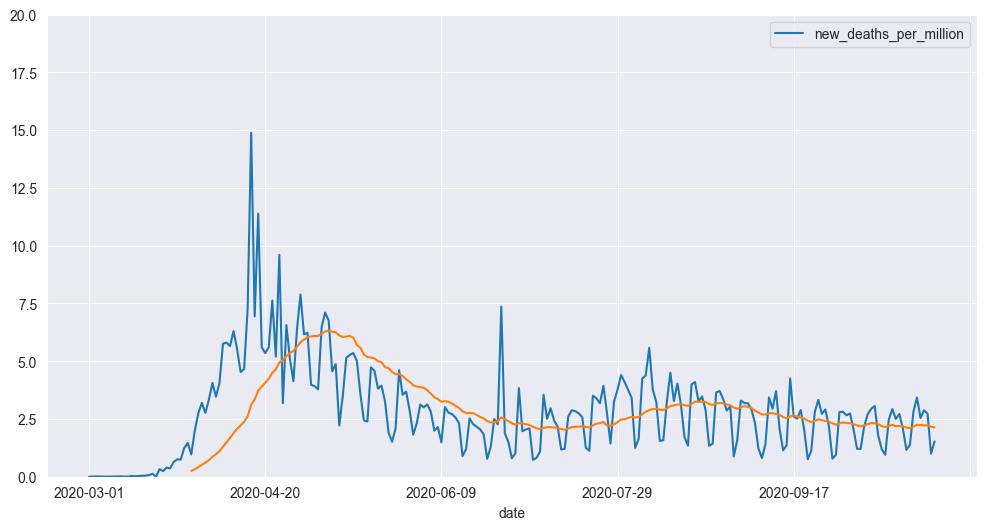

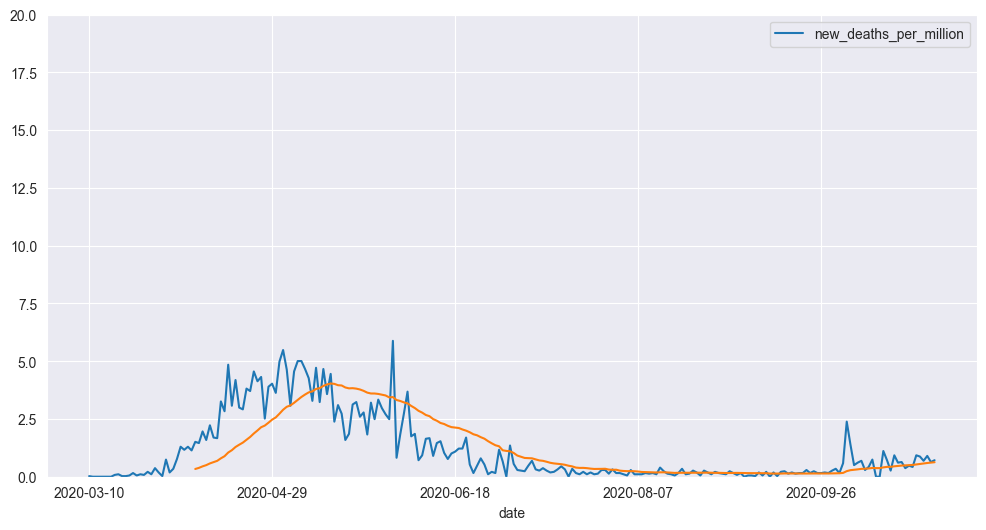

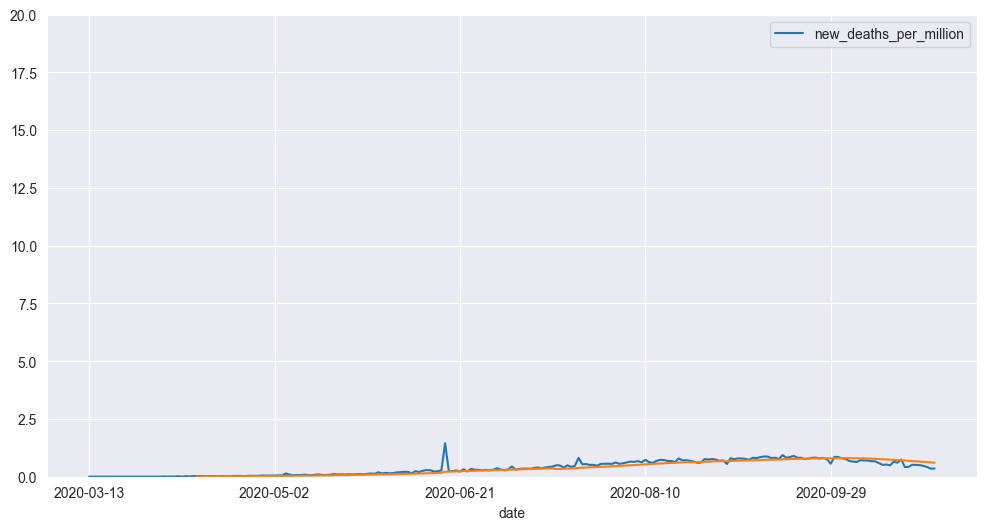

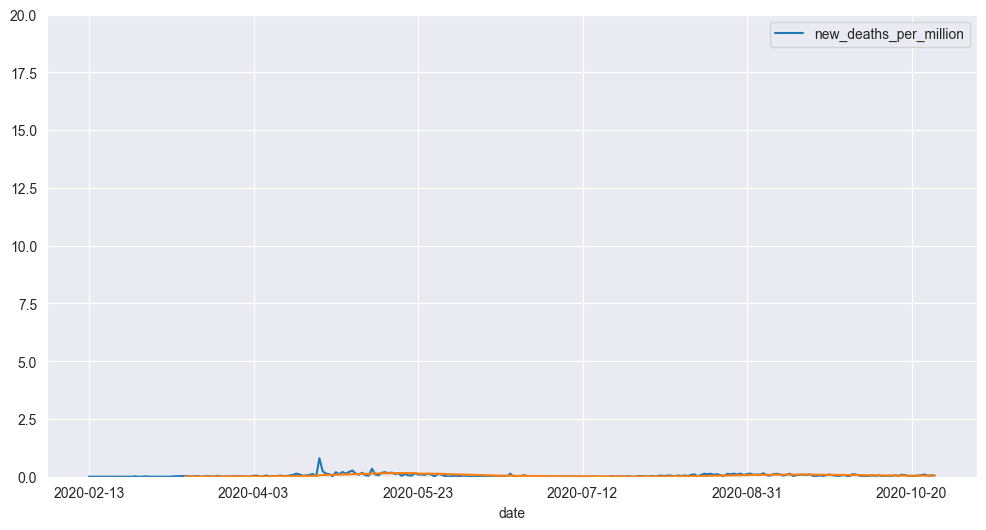

In [13]:
plot_covid_data('United States', 'new_deaths_per_million', True, 20)
plot_covid_data('Canada', 'new_deaths_per_million', True,20)
plot_covid_data('India', 'new_deaths_per_million', True, 20) 
plot_covid_data('Japan', 'new_deaths_per_million', True, 20)

#### How does diabetes effect death rate?

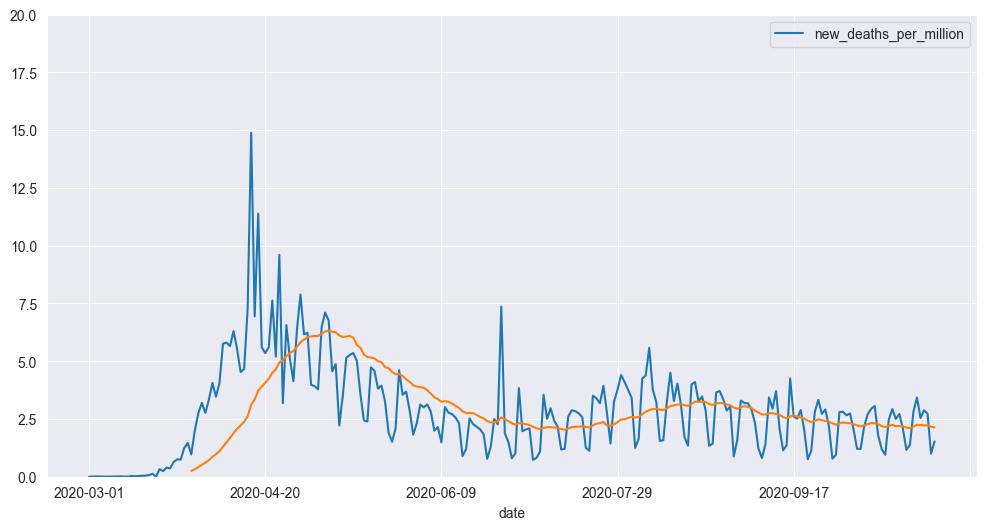

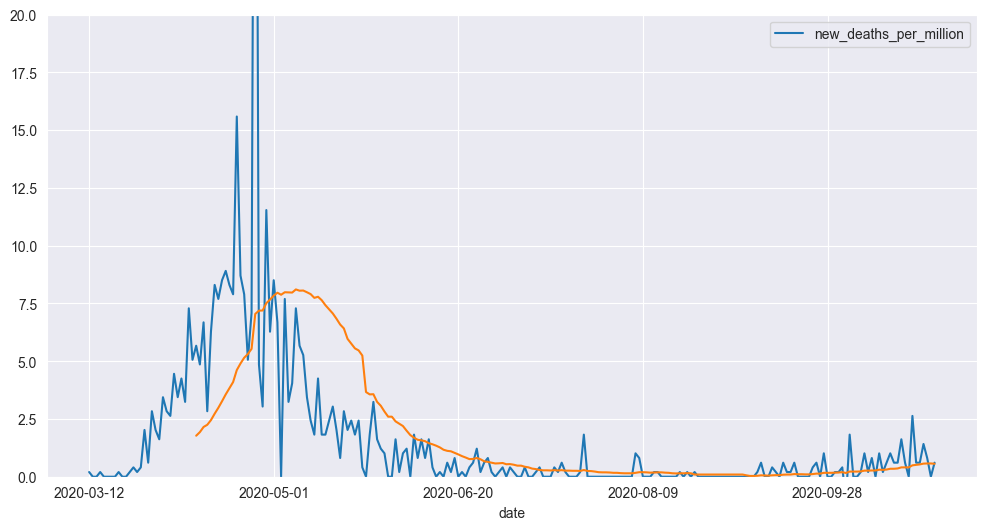

In [14]:
plot_covid_data('United States', 'new_deaths_per_million', True, 20)
plot_covid_data('Ireland', 'new_deaths_per_million', True, 20)

#### Does more testing effect death rate?

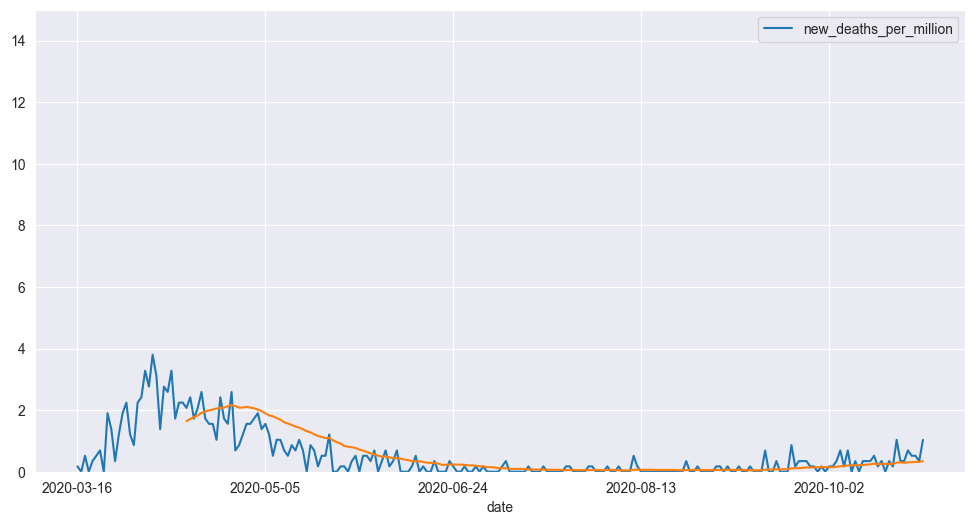

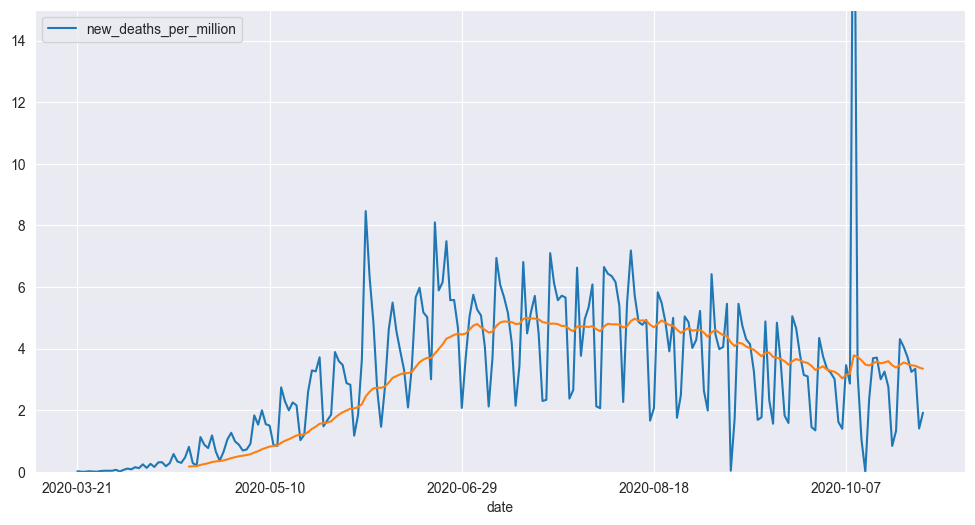

In [15]:
plot_covid_data('Denmark', 'new_deaths_per_million', True, 15)
plot_covid_data('Mexico', 'new_deaths_per_million', True, 15)

### All these investigations are just based on data